In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from tqdm import tqdm, trange
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

2024-05-11 15:16:07.438049: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 15:16:07.438079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 15:16:07.438692: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-11 15:16:07.442164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 15:16:07.967859: W tensorflow/compiler/tf2

In [2]:
# 기본 Config
configs = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'data_path': './data/train.csv',
    'eval_path': './data/test.csv',
    'save_path': './models',
    'n_labels': 6,
    'tokenizer_name': 'google-bert/bert-large-uncased',
    'model_name': 'google-bert/bert-large-uncased',
    'MAX_LENGTH': 512,
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'patience': 8,
    'learning_rate': 2e-5,
    'weight_decay': 0.001
}

In [3]:
# 데이터 로드
df = pd.read_csv(configs['data_path'])
df.drop(columns='essay_id', inplace=True)
df.rename(columns={'full_text': 'text', 'score': 'label'}, inplace=True)
df.head()

,text,label
0,Many people have car where they live. The thin...,3
1,I am a scientist at NASA that is discussing th...,3
2,People always wish they had the same technolog...,4
3,"We all heard about Venus, the planet without a...",4
4,"Dear, State Senator\n\nThis is a letter to arg...",3


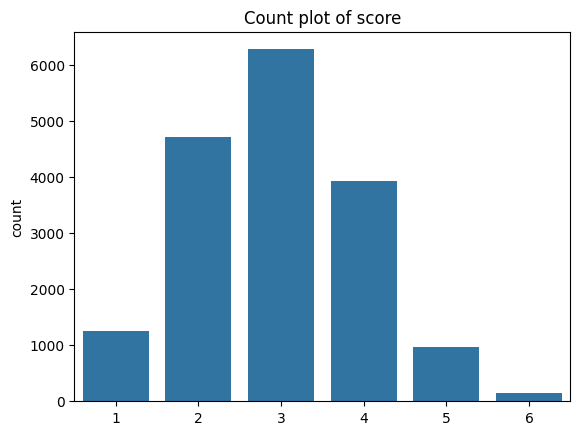

In [4]:
# 점수 Countplot
sns.countplot(x=df['label'].to_list())
plt.title('Count plot of score')
plt.show()

In [5]:
# nltk 토크나이저
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/yjg1005/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

100%|██████████| 17307/17307 [00:24<00:00, 719.06it/s]


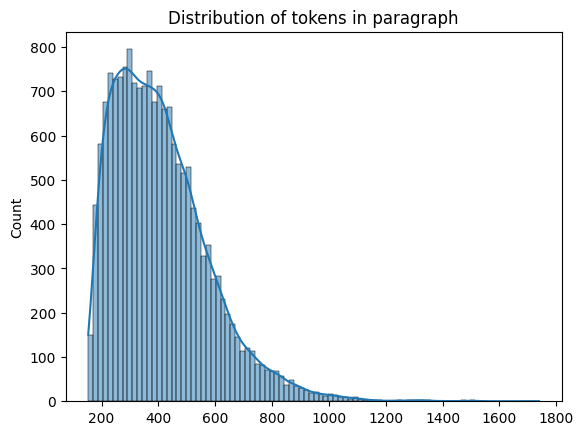

In [6]:
# 토큰화 이후 토큰 분포 확인
n_tokens = df['text'].progress_apply(lambda x: len(word_tokenize(x))).to_list()
sns.histplot(n_tokens, kde=True)
plt.title('Distribution of tokens in paragraph')
plt.show()

In [7]:
# 훈련, 검증 데이터 분리
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df.label.values, random_state=0)

In [8]:
train_df.head()

,text,label
2554,Isn't it strange that cars are one of the most...,1
16092,"Some people think that the crater in Mars, is ...",3
8866,in german suburbs residents are pioneers and t...,2
4520,"In the article ""Driverless Cars Are Coming,"" t...",4
6283,Being able to read someones elses emotions and...,2


In [9]:
# 데이터셋 구성
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(train_df)
dataset['val'] = Dataset.from_pandas(val_df)
dataset = dataset.remove_columns('__index_level_0__')
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 13845
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 3462
    })
})

In [10]:
# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(configs['tokenizer_name'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
# 문장 토큰화
def tokenize(data):
    return tokenizer(data['text'], max_length=configs['MAX_LENGTH'], padding=True, truncation=True)

dataset['train'] = dataset['train'].map(tokenize, batched=True, batch_size=configs['BATCH_SIZE'])
dataset['val'] = dataset['val'].map(tokenize, batched=True, batch_size=configs['BATCH_SIZE'])

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

In [12]:
# 라벨링
def encode(data):
    data['label'] = np.eye(configs['n_labels'])[np.array(data['label']) - 1]
    return data

dataset['train'] = dataset['train'].map(encode, batched=True, batch_size=configs['BATCH_SIZE'])
dataset['val'] = dataset['val'].map(encode, batched=True, batch_size=configs['BATCH_SIZE'])

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

In [13]:
# LLM 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(configs['model_name'], num_labels=configs['n_labels'])
model = model.to('cuda')
model

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,

In [14]:
# LoRA 적용 준비
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=8, 
    lora_alpha=32, 
    # target_modules=["query_key_value"], 
    # target_modules=[
    # "q_proj",
    # "up_proj",
    # "o_proj",
    # "k_proj",
    # "down_proj",
    # "gate_proj",
    # "v_proj"],
    lora_dropout=0.03, 
    bias="none", 
    task_type="CAUSAL_LM"
)

In [15]:
# LoRA 적용
model = get_peft_model(model, config)
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 1024, padding_idx=0)
          (position_embeddings): Embedding(512, 1024)
          (token_type_embeddings): Embedding(2, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-23): 24 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.03, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(i

In [16]:
# 훈련 파라미터 준비
args = TrainingArguments(
    configs['save_path'],
    evaluation_strategy='epoch',
    eval_steps=1,
    logging_strategy='epoch',
    logging_steps=1,
    logging_dir=os.path.join(configs['save_path'],'logs'),
    save_strategy = "epoch",
    save_steps=1,
    save_total_limit=3,
    num_train_epochs=configs['EPOCHS'],
    per_device_train_batch_size=configs['BATCH_SIZE'],
    per_device_eval_batch_size=configs['BATCH_SIZE'],
    learning_rate=configs['learning_rate'],
    weight_decay=configs['weight_decay'],
    metric_for_best_model='eval_loss',
    load_best_model_at_end=True,
    report_to='tensorboard'
)

In [17]:
# 평가 기준 정의
metric = load_metric('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    references = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=references)

In [18]:
# Trainer 객체 정의
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['val'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = configs['patience'])]
)

In [20]:
# 훈련 시작
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.362100,0.334726,0.556326
2,0.334800,0.318496,0.580589
3,0.322200,0.312027,0.584922
4,0.315000,0.308043,0.585211
5,0.310200,0.309216,0.582611
6,0.305800,0.307074,0.575101
7,0.303300,0.299678,0.586077
8,0.301300,0.295663,0.597054
9,0.298800,0.299938,0.584633
10,0.294100,0.296909,0.594165


KeyboardInterrupt: 

In [ ]:
# Without LoRA
# +-----------------------------------------------------------------------------------------+
# | NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
# |-----------------------------------------+------------------------+----------------------+
# | GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
# | Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
# |                                         |                        |               MIG M. |
# |=========================================+========================+======================|
# |   0  NVIDIA GeForce RTX 3090        Off |   00000000:08:00.0 Off |                  N/A |
# | 75%   80C    P2            415W /  420W |   21946MiB /  24576MiB |     98%      Default |
# |                                         |                        |                  N/A |
# +-----------------------------------------+------------------------+----------------------+

# +-----------------------------------------------------------------------------------------+
# | Processes:                                                                              |
# |  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
# |        ID   ID                                                               Usage      |
# |=========================================================================================|
# |    0   N/A  N/A     10575      C   /bin/python3                                21940MiB |
# +-----------------------------------------------------------------------------------------+

# With LoRA
# +-----------------------------------------------------------------------------------------+
# | NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
# |-----------------------------------------+------------------------+----------------------+
# | GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
# | Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
# |                                         |                        |               MIG M. |
# |=========================================+========================+======================|
# |   0  NVIDIA GeForce RTX 3090        Off |   00000000:08:00.0 Off |                  N/A |
# | 80%   80C    P2            410W /  420W |    3918MiB /  24576MiB |     90%      Default |
# |                                         |                        |                  N/A |
# +-----------------------------------------+------------------------+----------------------+

# +-----------------------------------------------------------------------------------------+
# | Processes:                                                                              |
# |  GPU   GI   CI        PID   Type   Process name                              GPU Memory |
# |        ID   ID                                                               Usage      |
# |=========================================================================================|
# |    0   N/A  N/A     10430      C   /bin/python3                                 3912MiB |
# +-----------------------------------------------------------------------------------------+

In [21]:
# 검증 데이터 평가
predictions, labels = [], []
for i in trange(len(dataset['val']['text']), desc='Evaluating'):
    text = dataset['val']['text'][i]
    label = dataset['val']['label'][i]
    inputs = tokenizer(text, max_length=configs['MAX_LENGTH'], padding=True, truncation=True, return_tensors='pt').to('cuda')
    outputs = model(**inputs)
    pred = np.argmax(outputs['logits'].to('cpu').detach().numpy(), axis=-1)[0] + 1
    label = np.argmax(label) + 1
    predictions.append(pred)
    labels.append(label)

Evaluating:   0%|          | 0/3462 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 3462/3462 [02:12<00:00, 26.10it/s]


In [22]:
# 분류 결과 보고
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           1       0.83      0.18      0.29       251
           2       0.66      0.69      0.68       945
           3       0.62      0.69      0.65      1256
           4       0.56      0.60      0.58       785
           5       0.45      0.42      0.43       194
           6       0.00      0.00      0.00        31

    accuracy                           0.61      3462
   macro avg       0.52      0.43      0.44      3462
weighted avg       0.62      0.61      0.60      3462



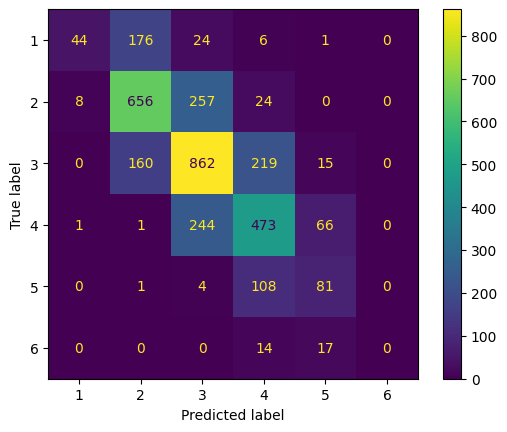

In [23]:
# 혼동행렬
cm = confusion_matrix(labels, predictions, labels=list(set(labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(labels)))
disp.plot()
plt.show()

In [24]:
df_test = pd.read_csv(configs['eval_path'])
df_test

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [25]:
# Test 데이터 예측
test_predictions = []
for i in df_test.index:
    text = df_test.loc[i, 'full_text']
    inputs = tokenizer(text, max_length=configs['MAX_LENGTH'], padding=True, truncation=True, return_tensors='pt').to('cuda')
    outputs = model(**inputs)
    pred = np.argmax(outputs['logits'].to('cpu').detach().numpy(), axis=-1)[0] + 1
    test_predictions.append(pred)
df_test['prediction'] = test_predictions

In [26]:
df_test

,essay_id,full_text,prediction
0,000d118,Many people have car where they live. The thin...,2
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
